# EE675A: Assignment 3
**Name**:  Praneat Data                            </br>
**Roll No.**:  210740

## Part A : Cart Pole Balancing using Policy Gradient: REINFORCE

In [1]:
!pip install pygame
!pip install gymnasium
%matplotlib inline
import gymnasium as gym
import pygame
import matplotlib
import numpy as np
import time
import random
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
env=gym.make('CartPole-v1')
env.reset()
# env.render()  
time.sleep(0.1)

In [3]:
env.step(1)

(array([ 0.04499863,  0.16300938,  0.04040621, -0.25292787], dtype=float32),
 1.0,
 False,
 False,
 {})

### 1.  Expression for gradient of the policy

$\pi(A_t \vert \bm{S_t}, \bm{\theta}) = \text{softmax}(\bm{\theta_{A_t}} \cdot \bm{S_t}) = \frac{\exp(\bm{\theta_{A_t}}^T\bm{S_t})}{\sum_{i=1}^{n} \exp(\bm{\theta_i}^T\bm{S_t})}$
$\newline \nabla \ln \pi(A_t \vert \bm{S_t}, \bm{\theta}) = \nabla \ln \exp(\bm{\theta_t}^T\bm{S_t}) - \nabla \ln \sum_{i=1}^{n} \exp(\bm{\theta_i}^T\bm{S_t})$
$$
\nabla_{k=A_t} \ln \pi(A_t \vert \bm{S_t}, \bm{\theta}) =\bm{S_t} (1 - \pi(k \vert \bm{S_t}, \bm{\theta}))\\
\nabla_{k \neq A_t} \ln \pi(A_t \vert \bm{S_t}, \bm{\theta}) =\bm{S_t} (-\pi(k \vert \bm{S_t}, \bm{\theta}))
$$


### 2. Implement REINFORCE algorithm with appropriate choice of algorithm parameters

In [4]:
def softmaxPolicy(theta, state):
    state = np.array(state)
    return np.exp(np.dot(theta, state)) / np.exp(np.dot(theta, state)).sum()

def gradientSFP(theta, state, action):
    return np.array([np.array(state) * ((action == i) - softmaxPolicy(theta, state)[i]) for i in range(2)])

In [5]:
def generateEpisode(policy, maxSteps=500):
    states = []
    actions = []
    rewards = []
    state = env.reset()[0]

    for _ in range(maxSteps):
        states.append(state)
        action = random.choices([0, 1], weights=softmaxPolicy(policy, state))[0]
        state, reward, done, trunc, info = env.step(action)
        actions.append(action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards, len(states)

In [6]:
def REINFORCE(episodes, maxSteps, discount, alpha):
    # Initializing with an equal policy
    theta = np.zeros(shape=(2, 4))
    episodeReward = []

    for _ in range(episodes):
        states, actions, rewards, T = generateEpisode(theta, maxSteps)
        # print(T)
        G_array = []
        for t in range(T):
            G = sum([pow(discount, k-t) * rewards[k] for k in range(t, T)])
            G_array.append(G)
            theta = theta + alpha * pow(discount, t) * G * gradientSFP(theta, states[t], actions[t])
        episodeReward.append(sum(rewards))

    return theta, episodeReward

### 3. Plot the training rewards over 1000 episodes

In [7]:
a, b = REINFORCE(1000, 500, 1, 0.001) 

Text(0.5, 1.0, 'Training Rewards')

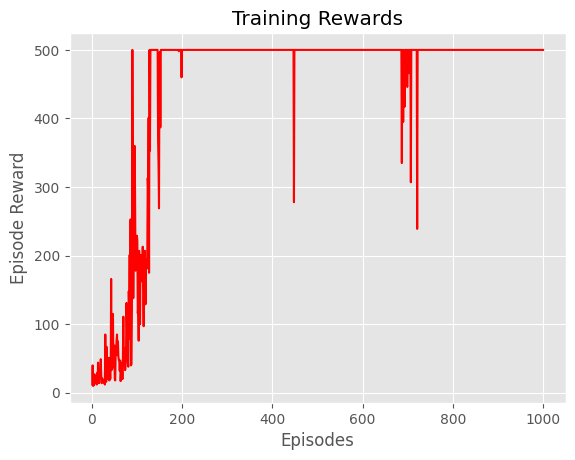

In [8]:
plt.plot(range(1,1001),b,color='red')
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.title('Training Rewards')

### 4. Test the trained policy and compute the average reward over 5 episodes

In [9]:
maxSteps = 500
episodeRewardT = []
for episode in range(1, 6):
    states, actions, rewards, T = generateEpisode(a, maxSteps)
    episodeRewardT.append(sum(rewards))
    print("episode", episode, ": ", episodeRewardT[-1])

print("\nAverage Reward: ", np.array(episodeRewardT).mean())


episode 1 :  500.0
episode 2 :  500.0
episode 3 :  500.0
episode 4 :  500.0
episode 5 :  500.0

Average Reward:  500.0


### 5. Implement REINFORCE algorithm with baseline as shown in Figure 2 with appropriate choice of algorithm parameters.

In [10]:
def valueFunc(weights, state):
    return np.dot(weights, np.array(state))

def gradientVF(weights, state):
    return np.array(state)

In [11]:
## Function to generate a single episode
def generateEpisode(policy, maxSteps=500):
    states = []
    actions = []
    rewards = []
    state = env.reset()[0]

    for _ in range(maxSteps):
        states.append(state)
        action = random.choices([0, 1], weights=softmaxPolicy(policy, state))[0]
        state, reward, done, trunc, info = env.step(action)
        actions.append(action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards, len(states)

In [12]:
def REINFORCE_baseline(episodes, maxSteps, discount, alpha_t, alpha_w):
    # Initializing with an equal policy
    theta = np.zeros(shape=(2, 4))
    weights = np.zeros(shape=(4))
    episodeReward = []

    for _ in range(episodes):
        states, actions, rewards, T = generateEpisode(theta, maxSteps)
        G_array = []
        for t in range(T):
            G = sum([pow(discount, k-t) * rewards[k] for k in range(t, T)])
            G_array.append(G)
            delta = G - valueFunc(weights, states[t])
            weights = weights + alpha_w * delta * gradientVF(weights, states[t])
            theta = theta + alpha_t * pow(discount, t) * delta * gradientSFP(theta, states[t], actions[t]) 
        episodeReward.append(sum(rewards))

    return theta, weights, episodeReward

In [13]:
A, B, C = REINFORCE_baseline(1000, 500, 1, 0.001, 0.001)

### 6. Compare and plot the training performance for both the algorithms

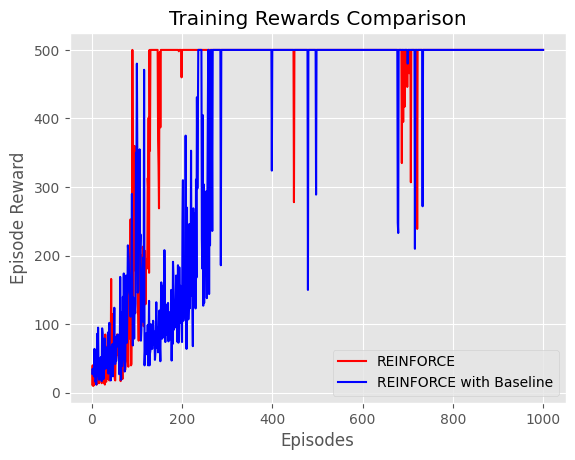

In [14]:
plt.plot(range(1, 1001), b, color='red')
plt.plot(range(1, 1001), C, color='blue')
plt.xlabel('Episodes')
plt.ylabel('Episode Reward')
plt.title('Training Rewards Comparison')
plt.legend(['REINFORCE', 'REINFORCE with Baseline'])